## dataset functions

In [14]:
# dataset = "exp_density"
# from exp_density_polynomial import *
# dataset = "cvar"
# from cvar import *
# dataset = "energy"
# from energy import *
dataset = "kelly"
from kelly import *
# dataset = "news_vendor"
# from news_vendor import *

device = cpu


## osmm

In [15]:
from osmm import OSMM

## generate random data

In [16]:
W = generate_random_data()
W_validation = generate_random_data()

## solve

In [17]:
osmm_prob = OSMM(f_torch=my_objf_torch, g_cvxpy=get_cvxpy_description, get_initial_val=get_initial_val,
                 W=W, W_validate=W_validation)
osmm_prob.solve(solver="MOSEK")

Hutchinson #iters 28 rel. incr. 4.9444977431834556e-05 est. tr. 15300.604779031992
lam_0 86.93525442631814 Hutchinson time cost,  0.11012721061706543


/Users/xinyueshen/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:163: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


iter= 10 objf_k+1= 0.10799574106931686 L_k+1= -0.17995807127183383 lam_k+1= 3.2990539313971796 tk= 0.5 mu_k+1 1.886358152800001 ||G_k+1||_F= 78.46102234120376 tau_k+1 1.748901143984908
iter= 20 objf_k+1= -0.0003727609582711011 L_k+1= -0.14977838675858846 lam_k+1= 1.0446336808981211 tk= 1.0 mu_k+1 0.27850097600940243 ||G_k+1||_F= 114.90527939413425 tau_k+1 3.750915691092061
iter= 30 objf_k+1= -0.06812980026006699 L_k+1= -0.14977838675858846 lam_k+1= 0.6195672903690266 tk= 1.0 mu_k+1 0.04111774507034097 ||G_k+1||_F= 230.30370655862836 tau_k+1 15.068124220068977
iter= 40 objf_k+1= -0.0870012417435646 L_k+1= -0.094179051693485 lam_k+1= 0.16578893960475805 tk= 0.5 mu_k+1 0.011477234470328487 ||G_k+1||_F= 225.49165889234345 tau_k+1 14.445025065346865
iter= 50 objf_k+1= -0.08877845108509064 L_k+1= -0.09119599954544344 lam_k+1= 0.10323787566301222 tk= 1.0 mu_k+1 0.006056902946589489 ||G_k+1||_F= 244.943294077592 tau_k+1 17.04466400954026
      Time elapsed (secs): 4.256730.



## get results

In [18]:
x_soln = osmm_prob.method_results["x_best"]
Xs = osmm_prob.method_results["X_iters"]

In [19]:
max_num_rounds = len(osmm_prob.method_results["objf_iters"])
iters_taken = osmm_prob.method_results["iters_taken"]

In [20]:
objfs = np.array(osmm_prob.method_results["objf_iters"])
for i in range(1, iters_taken):
    objfs[i] = np.min(osmm_prob.method_results["objf_iters"][0:i + 1])
objfs[iters_taken::] = objfs[iters_taken]
objf_min = np.min(objfs[0:iters_taken + 1])

In [21]:
objfs_val = np.array(osmm_prob.method_results["objf_validation_iters"])
objfs_val[iters_taken::] = objfs_val[iters_taken]

In [22]:
lower_bounds = np.array(osmm_prob.method_results["lower_bound_iters"])
lower_bounds[iters_taken::] = lower_bounds[iters_taken]

In [23]:
opt_res_norms = np.array(osmm_prob.method_results["opt_res_iters"])
start_idx = 1
for i in range(start_idx, iters_taken):
    opt_res_norms[i] = np.min(osmm_prob.method_results["opt_res_iters"][start_idx:i + 1])
opt_res_norms[iters_taken::] = opt_res_norms[iters_taken]

## plots

/Users/xinyueshen/Documents/research/osmm/examples/kelly.py:179: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  a.stem([i for i in range(n - 1)], outcomes_count[0:n - 1] / N, markerfmt=' ')
/Users/xinyueshen/Documents/research/osmm/examples/kelly.py:191: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  b.stem([i for i in range(n)], x_best, markerfmt=' ')


mean 0.08877845836182333


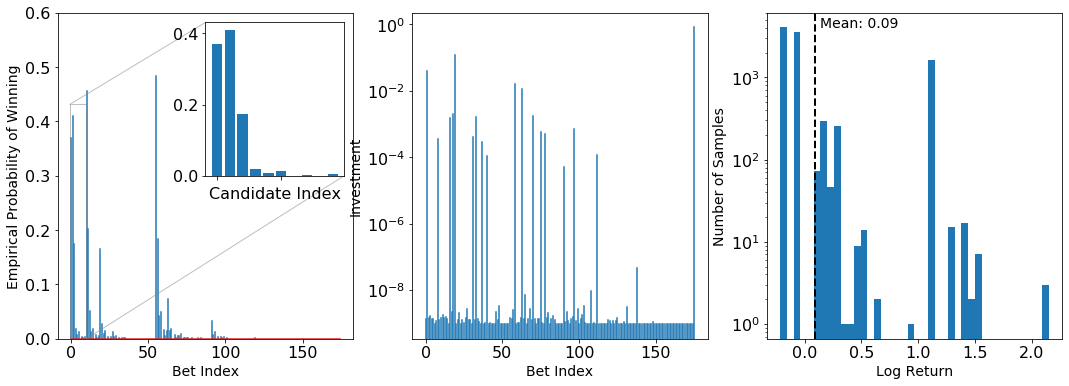

In [24]:
if dataset == "exp_density":
    my_plot_exp_density_one_result(Xs, objfs, iters_taken)
else:
    my_plot_one_result(W, x_soln, is_save_fig=False, figname="cvar_pnt9_result.pdf")

In [25]:
linewidth = 2
fontsize = 16
font = {'family': 'serif',
        'size': fontsize,
        }

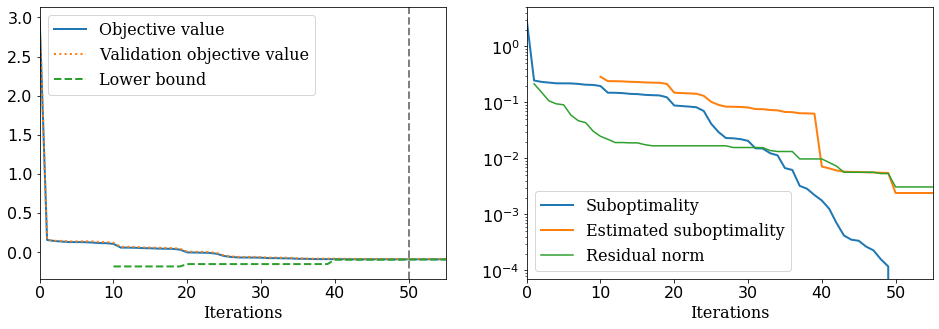

In [26]:
fig = plt.figure(tight_layout=False, figsize=(16, 5))
gs = gridspec.GridSpec(1, 2)
plt.rcParams.update({'font.size': fontsize})

plot1 = fig.add_subplot(gs[0, 0])
rounds = range(0, max_num_rounds)
if osmm_prob.method_results["iters_taken"] < max_num_rounds:
    plot1.axvline(osmm_prob.method_results["iters_taken"], color='gray', linestyle='dashed', linewidth=linewidth)
##objf
plot1.plot(np.array(rounds), objfs, linewidth=linewidth, label="Objective value")
##objf_validation
plot1.plot(np.array(rounds), objfs_val, ':', linewidth=linewidth, label="Validation objective value")
##l_k
plot1.plot(np.array(rounds), lower_bounds, '--', linewidth=linewidth, label="Lower bound")

plot1.set_xlabel("Iterations", fontdict=font)
plot1.legend(prop=font)

#=========================================================================================================
plot2 = fig.add_subplot(gs[0, 1])
##subopt
plot2.plot(np.array(rounds), objfs - objf_min, linewidth=linewidth, label="Suboptimality")
## gaps
gaps = objfs - lower_bounds
plot2.plot(rounds, gaps, linewidth=linewidth, label="Estimated suboptimality")
## residual norm
plot2.plot(rounds[start_idx::], opt_res_norms[start_idx::] / n, label="Residual norm", color='#2ca02c')

plot2.set_xlabel("Iterations", fontdict=font)
plot2.set_yscale("log")
plot2.legend(prop=font)

plot_iter_lim = iters_taken + 5
ylim = None
if plot_iter_lim is not None:
    plot1.set_xlim([0, plot_iter_lim])
    plot2.set_xlim([0, plot_iter_lim])
if ylim is not None:
    plot2.set_ylim([ylim[0], ylim[1]])